<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task-1:--Numerical-Prediction" data-toc-modified-id="Task-1:--Numerical-Prediction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Task 1:  Numerical Prediction</a></span></li><li><span><a href="#Task-2:--Classification" data-toc-modified-id="Task-2:--Classification-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Task 2:  Classification</a></span></li><li><span><a href="#Task-3:--Confusion-Matrix" data-toc-modified-id="Task-3:--Confusion-Matrix-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Task 3:  Confusion Matrix</a></span></li><li><span><a href="#Task-4:-Thought-Experiment" data-toc-modified-id="Task-4:-Thought-Experiment-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Task 4: Thought Experiment</a></span></li></ul></div>

**Solution on Support Vector Machines**

Charles Liu

In [1]:
library(caret)

Loading required package: lattice

Loading required package: ggplot2



In [2]:
load("SalePrice-Churn.RData")

# Task 1:  Numerical Prediction

The following data is the type of data that businesses like zillow.com use to estimate the likely selling price of a home.  The `SalePrice` column gives the log10 of the eventual selling price (1000 houses in `TRAIN`, 460 houses in `HOLDOUT`).  A total of 64 characteristics have been recorded about each house (the data has already been crudely cleaned, with rare levels of categorical variables combined when appropriate, missing values recoded as 0s for numerical variables or as a new level for categorical variables).

In [3]:
summary(TRAIN$SalePrice)
summary(is.na(HOLDOUT$SalePrice))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  4.548   5.117   5.212   5.224   5.332   5.878 

   Mode    TRUE 
logical     460 

a.  Why has this problem been set up so that you are predicting the log10 of the sale prices instead of the actual sale prices themselves?  Make and include a histogram of the "un-logged" sale prices to help justify your answer.

**Response:** The distribution of the actual sale prices is quite skewed. Most algorithms in business analytics do better when the distribution of what we want to predict is roughly symmetric, and the distribution of the logarithms is quite symmetric indeed.

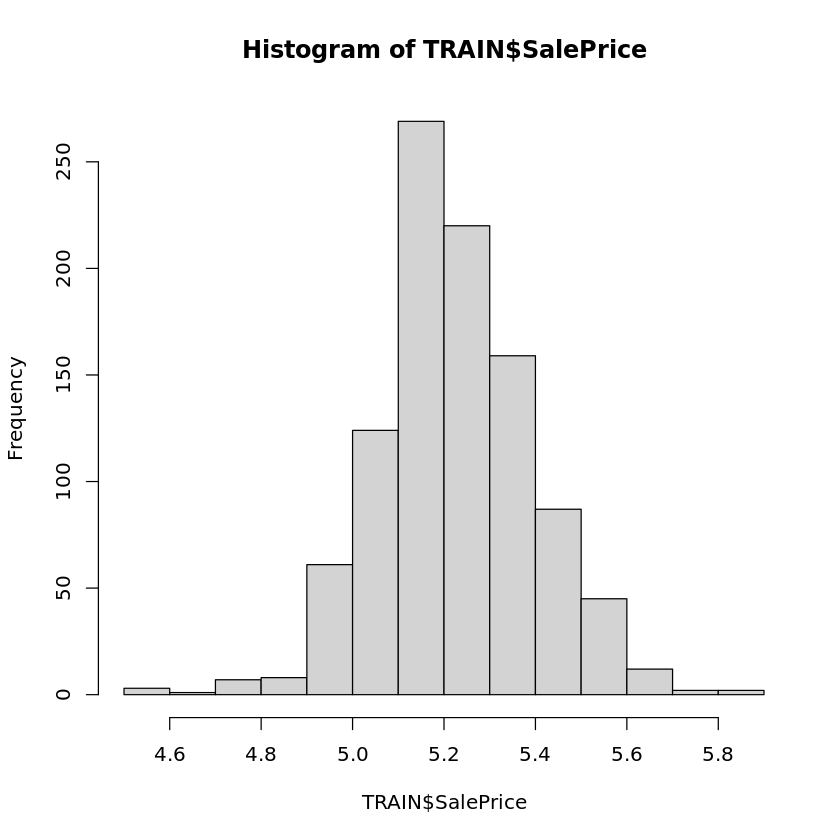

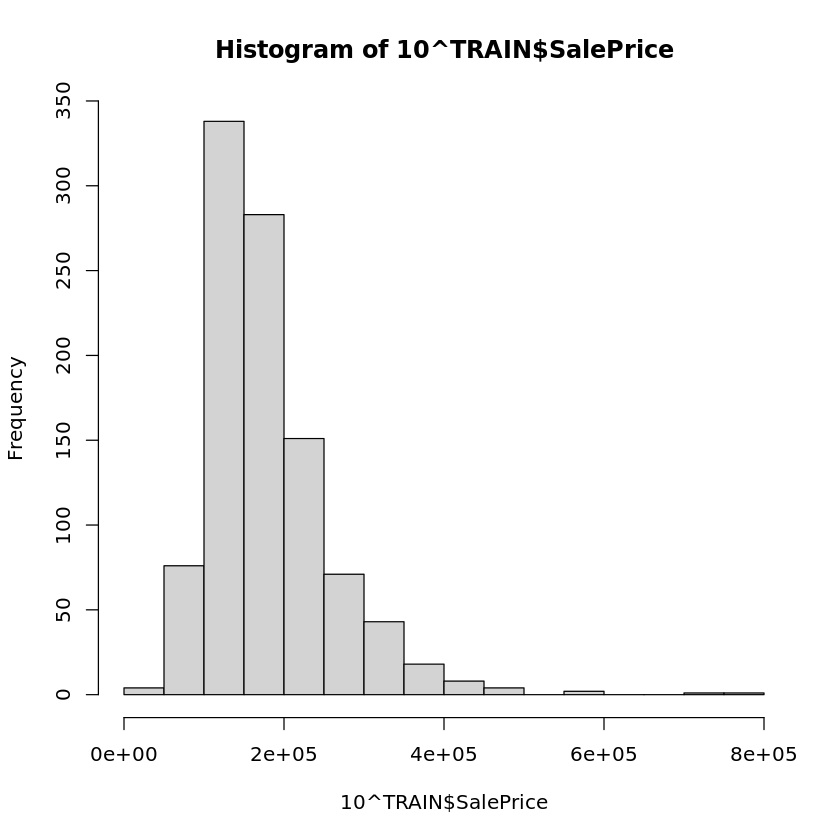

In [4]:
hist( TRAIN$SalePrice)
hist( 10^TRAIN$SalePrice )

b. Set up `fitControl` so that vanilla 5-fold crossvalidation is being used to estimate the generalization error, then provide estimates of the generalization error of a 

   *  Vanilla linear regression model
   *  Regularized linear regression model tuned over values of `alpha` of 0, 0.2, 0.4, 0.6, 0.8, 1 and values of `lambda` of 10 raised to the -3, -2.5, -2, ..., -1, -0.5 powers.
   *  Vanilla partition model tuned over values of `cp` of 10 raised to the -5, -4.5, -4, ..., -1.5, -1 powers
   *  Random forest model tuned over values of `mtry` of 1, 5, 10, 25, 40, 60 (do not add `importance=TRUE` as an argument)

Sanity checks are provided (last 2 numbers of each antipated output).

With vanilla linear regression, you can ignore the `rank-deficient` warning (some of the predictors are highly correlated).

In [5]:
fitControl <- trainControl(method="cv", number=5)

set.seed(474); GLM <- train(SalePrice~., data=TRAIN, method='glm',
                            trControl=fitControl, preProc=c("center", "scale") )
GLM$results

glmnetGrid <- expand.grid(alpha = seq(0,1,by=0.2),lambda = 10^seq(-3,-0.5,by=0.5))   
set.seed(474); GLMnet <- train(SalePrice~., data=TRAIN, method='glmnet', tuneGrid=glmnetGrid,
                            trControl=fitControl, preProc=c("center", "scale") )
GLMnet$results[rownames(GLMnet$bestTune),]   

treeGrid <- expand.grid(cp=10^seq(-5,-1,by=0.5))
set.seed(474); TREE <- train(SalePrice~., data=TRAIN, method='rpart', tuneGrid=treeGrid,
                             trControl=fitControl, preProc = c("center", "scale"))
TREE$results[rownames(TREE$bestTune),]

forestGrid <- expand.grid(mtry=c(1, 5, 10, 25, 40, 60))  #put in values 
set.seed(474); FOREST <- train(SalePrice~., data=TRAIN, method='rf', tuneGrid=forestGrid,
                               trControl=fitControl, preProc = c("center", "scale"))
FOREST$results[rownames(FOREST$bestTune),]

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


,parameter,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,none,0.05935016,0.8814068,0.03983344,0.01138163,0.04420317,0.001742781


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


,alpha,lambda,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14,0.4,0.003162278,0.05661145,0.8903986,0.03761459,0.01160492,0.04432234,0.002689639


,cp,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,0.0003162278,0.08264688,0.769343,0.05914337,0.007650637,0.03077231,0.00520896


,mtry,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,25,0.05981388,0.8844924,0.03966381,0.008824711,0.03013993,0.004150378


c.  Support vector machines project the data into a higher-dimensional dataspace (roughly, by automatically creating new predictor variables from the ones that were collected).  It creates these variables implicitly using a "kernel" matrix, and there's a few common kernels people use.  The linear kernel is roughly equivalent to using the predictor variables and all two-way interactions.  The polynomial kernel makes powers (up to a specified number) of the predictor variables and interactions as new variables.  The Gaussian or Radial Basis kernel creates (in effect) an infinite number of polynomial terms.  The hope is that in this higher-dimensional dataspace, the relationships are linear enough to be well-model by a linear regression (but still with a slight twist in that not all errors made by the model count against it).

Tune a support vector machine that uses a linear kernel (`method=svmLinear`) with values of cost (`C`) of 10 raised to -3.5, -3, -2.5, -2, -1.5 powers.   Print to the screen the contents of the `$results` component of the object output by `train`.

In [6]:
svmGrid <- expand.grid(C=10^seq(-3.5,-1.5,by=.5) )
set.seed(474); SVM <- train(SalePrice~., data=TRAIN, method='svmLinear', tuneGrid = svmGrid,
                             trControl=fitControl, verbose=FALSE, preProc = c("center", "scale"))

SVM$results

,C,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0003162278,0.06572029,0.8751197,0.04415940,0.00917158,0.03752124,0.003627521
2,0.0010000000,0.05685115,0.8924025,0.03706797,0.01057247,0.03936374,0.002844409
3,0.0031622777,0.05560064,0.8947267,0.03590994,0.01120052,0.04138045,0.002563946
4,0.0100000000,0.05597057,0.8929595,0.03621726,0.01181891,0.04398909,0.002499451
5,0.0316227766,0.05621553,0.8919886,0.03649126,0.01212454,0.04522698,0.002620093


d.  Tune a support vector machine that uses a polynomial kernel (`method=svmPoly`), which is roughly equivalent to a linear regression with all predictors and all two-way interactions including additional polynomial terms.

The parameter grid is given.

In [7]:
svmGrid <- expand.grid(degree=c(3,4), C=10^seq(-2,-0.5,by=.5), scale=10^seq(-3,-1.5,by=.5)) 
set.seed(474); SVMpoly <- train(SalePrice~., data=TRAIN, method='svmPoly', tuneGrid = svmGrid,
                                 trControl=fitControl, verbose=FALSE, preProc = c("center", "scale"))
SVMpoly$results[rownames(SVMpoly$bestTune),]

,degree,C,scale,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14,3,0.3162278,0.003162278,0.05420514,0.8973423,0.03382553,0.01428994,0.05426994,0.00315646


e.  Tune a support vector machine that uses the radial basis kernel (`method=svmRadial`) with the following tuning parameters.

In [8]:
svmGrid <- expand.grid( sigma=10^seq(-3.5,-1,by=.5),C=10^seq(-1,1,by=.5) )  
set.seed(474); SVMradial <- train(SalePrice~.,data=TRAIN, method='svmRadial', tuneGrid = svmGrid,
                                   trControl=fitControl, verbose=FALSE, preProc = c("center", "scale"))
SVMradial$results[rownames(SVMradial$bestTune),]

,sigma,C,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,0.001,3.162278,0.05316976,0.9033266,0.03425602,0.01041421,0.0360905,0.002364924


f.  Out to 3 numbers after the decimal place, record the estimated generalization errors and SDs of the models below.
Which model has the lowest estimated generalization error?
If we consider any model within 1 SD of "the best" to also be acceptable, which other models provide reasonable choices.

In [9]:
ALL.results <- rbind(GLM$results[,c('RMSE','RMSESD')],
      GLMnet$results[rownames(GLMnet$bestTune),c('RMSE','RMSESD')],
      TREE$results[rownames(TREE$bestTune),c('RMSE','RMSESD')],
      FOREST$results[rownames(FOREST$bestTune),c('RMSE','RMSESD')],
      SVM$results[rownames(SVM$bestTune),c('RMSE','RMSESD')],
      SVMpoly$results[rownames(SVMpoly$bestTune),c('RMSE','RMSESD')],
      SVMradial$results[rownames(SVMradial$bestTune),c('RMSE','RMSESD')])
rownames(ALL.results) <- c('GLM', 'GLMnet', 'Tree', 'Forest', 'SVMlinear', 'SVMpoly', 'SVMradial')
ALL.results[order(ALL.results$RMSE),]

,RMSE,RMSESD
,<dbl>,<dbl>
SVMradial,0.05316976,0.010414208
SVMpoly,0.05420514,0.014289940
SVMlinear,0.05560064,0.011200523
GLMnet,0.05661145,0.011604915
GLM,0.05935016,0.011381626
Forest,0.05981388,0.008824711
Tree,0.08264688,0.007650637


**Response:**

SVMradial has the lowest estimated generalization error.

All but the Tree look to be acceptable models since other models have RMSE within one standard deviation of the lowest.

# Task 2:  Classification

The `TELCO` dataframe contains a small part of a customer database from a telecommunications company (similar in nature to the `CHURN` data but for a different company).  

*We will use the data as-is*, and will use the entirety of the data when estimating the generalization errors of different models.  We lose the ability to have an independent assessment of the generalization error of the model on a holdout sample.

a. Make a `table` of the `Churn` column and report the estimated generalization accuracy of the naive model.

In [10]:
table(TELCO$Churn)
mean(TELCO$Churn == "No")


  No  Yes 
5163 1869 

[1] 0.734215

b.  Tune a support vector machine that uses the linear kernel (`method=svmLinear`) with the given values of the cost parameter `C`.

In [11]:
fitControl <- trainControl(method="cv", number=5)
svmGrid <- expand.grid( C=10^seq(-2.5,-1.5,by=.5) )
set.seed(474); SVM <- train(Churn~., data=TELCO, method='svmLinear', tuneGrid = svmGrid,
                             trControl=fitControl, verbose=FALSE, preProc = c("center", "scale"))
SVM$results[rownames(SVM$bestTune),]

,C,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.003162278,0.7996265,0.4524108,0.01313873,0.03714174


c.  Does the model convincingly beat the naive model when it comes to estimated accuracy?  Explain.

**Response:**  Yes. The accuracy is higher than 1 SD above the naive model.

# Task 3:  Confusion Matrix

**A question like this is likely to be on the exam.**

We have used the holdout sample as sanity check to ensure that the expected generalization of our selected model found during training is about the same as the actual error it makes on a set of "brand new" individuals.  The confusion matrix on the holdout sample provides more details about the types of errors made by model.

Note:  you may need to refer back to the relevant slides and notes to get a refresher on how to "read" the matrix. 

Imagine that the confusion matrix of a support vector machine model on a new set of 2000 customers of `TELCO` is as follows.

```
Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1343  103
       Yes  274  280
```

Calculate the requested quantities below, showing your work.

a.  If the "naive" model predicts "No" for every individual in the holdout sample, what is its accuracy?

**Response:**  There are a total of (1343+274=1617) `No`s in the holdout sample, so the accuracy is 1617/2000 = 0.8085

b.  What is the accuracy of the support vector machine?  

**Response:**  There are a total of (1343+280=1623) correct predictions, so the accuracy is 1623/2000 = 0.8115.

c.  Taking the `Yes` class to be the `positive` class, what is the false positive rate of the support vector machine?

**Response:**  A false positive is when the model predicts `Yes` but in actuality it is `No`. Of the 1617 `No`s in the holdout sample, 274 were predicted to be `Yes`, so 274/1617 = 16.9%.

d.  What is the false negative rate of the support vector machine?

**Response:** A false negative is when the model predicts `No` but in actuality it is `Yes`. Of the (103+280=383) `Yes`s in the holdout sample, 103 were predicted to be no, so 103/383 = 26.9%.

e.  Which of the two types of errors (false positive vs. false negative) would `TELCO` consider more damaging and why?

**Response:**  False negative. This means the model predicted the customer is not churn, but in actuality they did. The company missed out on a chance to retain the customer.

False positive refers to customers predicted to churn, but actually they would not. The company may spend some unnecessary efforts to retain these customers but that would not lead to bad consequences on the customers.

# Task 4: Thought Experiment

**A question like this is likely to be on the exam.**

The class label (star or dot) and two characteristics (`x1` and `x2`) of 300 individuals have been recorded.  The data space, with points encoded as their class labels, is displayed.

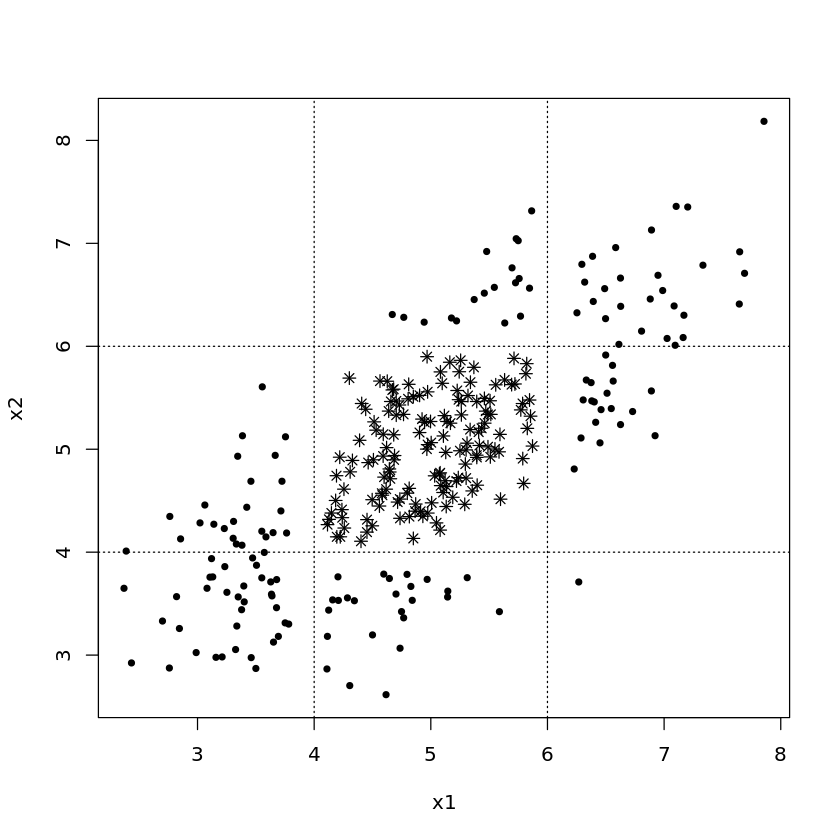

In [12]:
library(MASS)
set.seed(474)  
X <- mvrnorm(300,c(5,5),matrix(c(1,.8,.8,1),nrow=2))
for (i in 1:300) { 
  if( X[i,1] > 3.9 & X[i,1] < 6.1 & X[i,2] > 5.9 ) { X[i,2] <- X[i,2]+.3 }
  if( X[i,1] > 3.9 & X[i,1] < 6.1 & X[i,2] < 4.1 ) { X[i,2] <- X[i,2]-.3 }
  if( X[i,1] > 5.9 ) { X[i,1] <- X[i,1]+.3 }
  if( X[i,1] < 4.1 ) { X[i,1] <- X[i,1]-.3 }
  
  }
types <- c()
for (i in 1:300) {
  if(X[i,1] < 6 & X[i,2] < 6 & X[i,1] > 4 & X[i,2] > 4 ) { types[i] <- 8 } else { types[i] <- 20 }
}
plot( X,pch=types,xlab="x1",ylab="x2" )
abline(h=6,lty=3)
abline(h=4,lty=3)
abline(v=4,lty=3)
abline(v=6,lty=3)

a.  Would logistic regression be an effective model for making classifications?  Why or why not (be as specific as possible)?

**Response:**  No. Logistic regression assumes that the probability of belonging to a class either uniformly increases or uniformly decreases as the value a the predictor variable increases (we see the probability of being in the circle class is basically 100% for small/large values of x1 or x2, but small for values of x1 or x2 near 5)

b.  Explain why the plot indicates that a (vanilla) partition model should do a good job classifying individuals.

**Response:**  The vanilla partition model splits up the data space into rectangular regions, and individuals in the rectangular region `vote` as to class membership. We see that this set of rectangular regions achieves 100% classification accuracy, so a partition model should do well here.

c. (optional; not graded)  On a piece of scratch paper, draw a decision tree that would give 100% accuracy. Have the first rule be `x1<5` vs. `x1 >= 5`.

d. Obviously, no separating hyperplane exists in this data space. However, it is possible to separate the classes with a hyperplane in a three dimensionsal dataspace if we added a cleverly chosen variable x3 to the data. Come up with a definition of x3 that makes the two classes separable in three dimensional data space. Note: this won’t be a standard equation like x3 = x1^2 - x2. Rather, let x3 equal 1 if some condition regarding x1 and x2 is true, and 0 otherwise.

**Response:** Let x3 = 1 if both x1 and x2 are between 4 and 6, and 0 otherwise. The classes are now easily separated by the hyperplane x3=0.5 (star if above the plane, circle if below).